In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/churn-prediction-dataset/data_descriptions.csv
/kaggle/input/churn-prediction-dataset/train.csv
/kaggle/input/churn-prediction-dataset/test.csv


Import libraries
-

In [2]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

# Load dataset
df = pd.read_csv('/kaggle/input/churn-prediction-dataset/train.csv')

Confidence interval (95%)
-

In [3]:
# Select category variables
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
print(f"\nNumeric variables ({len(numeric_cols)}):\n", numeric_cols)

# Function to calculate category variables
def confidence_interval(series, confidence=0.95):
    data = series.dropna()
    n = len(data)
    mean = np.mean(data)
    std = np.std(data, ddof=1)
    se = std / np.sqrt(n)
    alpha = 1 - confidence
    t_crit = stats.t.ppf(1 - alpha/2, df=n-1)
    margin = t_crit * se
    lower = mean - margin
    upper = mean + margin

    return pd.Series({
        "Sample Size (n)": n,
        "Mean (x̄)": mean,
        "Std Dev (s)": std,
        "Std Error": se,
        "t-critical": t_crit,
        "Margin of Error": margin,
        "95% CI Lower": lower,
        "95% CI Upper": upper
    })

# Apply for all var
ci_results = df[numeric_cols].apply(confidence_interval).T

# Display the result
pd.set_option("display.float_format", lambda x: f"{x:,.3f}")
display(ci_results)


Numeric variables (10):
 ['AccountAge', 'MonthlyCharges', 'TotalCharges', 'ViewingHoursPerWeek', 'AverageViewingDuration', 'ContentDownloadsPerMonth', 'UserRating', 'SupportTicketsPerMonth', 'WatchlistSize', 'Churn']


,Sample Size (n),Mean (x̄),Std Dev (s),Std Error,t-critical,Margin of Error,95% CI Lower,95% CI Upper
AccountAge,"243,787.000",60.084,34.285,0.069,1.960,0.136,59.948,60.220
MonthlyCharges,"243,787.000",12.491,4.328,0.009,1.960,0.017,12.474,12.508
TotalCharges,"243,787.000",750.741,523.073,1.059,1.960,2.076,748.665,752.817
ViewingHoursPerWeek,"243,787.000",20.502,11.244,0.023,1.960,0.045,20.458,20.547
AverageViewingDuration,"243,787.000",92.264,50.505,0.102,1.960,0.200,92.064,92.465
ContentDownloadsPerMonth,"243,787.000",24.504,14.421,0.029,1.960,0.057,24.446,24.561
UserRating,"243,787.000",3.003,1.155,0.002,1.960,0.005,2.998,3.007
SupportTicketsPerMonth,"243,787.000",4.504,2.873,0.006,1.960,0.011,4.493,4.516
WatchlistSize,"243,787.000",12.019,7.193,0.015,1.960,0.029,11.990,12.047
Churn,"243,787.000",0.181,0.385,0.001,1.960,0.002,0.180,0.183


Because the sample is so large, the Standard Error and Margin of Error are very, very small --> We can estimate the true population mean with extremely high precision.

**Specific Examples
- ViewingHoursPerWeek:

The sample mean is 20.502 hours.

The 95% CI is [20.458, 20.547].

-> Conclusion: We are 95% confident that the true average viewing hours for the entire population is somewhere between 20.458 and 20.547 hours. This is a very precise estimate.


 Independent two-sample t-test to find the relationship between 2 groups churn and non-churn.
 Levene's test for the relationship between category variables.
 -
 Compare and display statisticable results.

In [4]:
# Select numeric and category variables
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
if 'Churn' in numeric_cols:
    numeric_cols.remove('Churn')

categorical_cols = df.select_dtypes(exclude=[np.number]).columns.tolist()

print(f"Numeric variables ({len(numeric_cols)}): {numeric_cols}")
print(f"Categorical variables ({len(categorical_cols)}): {categorical_cols}")

# Devide into 2 groups
churned = df[df['Churn'] == 1]
non_churned = df[df['Churn'] == 0]

Numeric variables (9): ['AccountAge', 'MonthlyCharges', 'TotalCharges', 'ViewingHoursPerWeek', 'AverageViewingDuration', 'ContentDownloadsPerMonth', 'UserRating', 'SupportTicketsPerMonth', 'WatchlistSize']
Categorical variables (11): ['SubscriptionType', 'PaymentMethod', 'PaperlessBilling', 'ContentType', 'MultiDeviceAccess', 'DeviceRegistered', 'GenrePreference', 'Gender', 'ParentalControl', 'SubtitlesEnabled', 'CustomerID']


In [5]:
# Apply T-test and Levene's test
def t_test_by_group(var):
    x1 = churned[var].dropna()
    x2 = non_churned[var].dropna()

    # Levene's Test for equal variances
    _, p_levene = stats.levene(x1, x2)
    equal_var = p_levene > 0.05  # True nếu phương sai bằng nhau

    # Independent samples t-test
    t_stat, p_value = stats.ttest_ind(x1, x2, equal_var=equal_var)

    return pd.Series({
        'Mean_Churned': x1.mean(),
        'Mean_NonChurned': x2.mean(),
        'Difference': x1.mean() - x2.mean(),
        'Levene_p': p_levene,
        'Equal Variance?': 'Yes' if equal_var else 'No',
        't-statistic': t_stat,
        'p-value': p_value,
        'Significant? (α=0.05)': 'Yes' if p_value < 0.05 else 'No'
    })

# T-test for numeric var
t_test_results = pd.DataFrame({var: t_test_by_group(var) for var in numeric_cols}).T

In [6]:
pd.set_option('display.float_format', lambda x: f"{x:,.4f}")

print("\n===================== T-TEST + LEVENE RESULTS =====================")
display(t_test_results.sort_values('p-value'))


===================== T-TEST + LEVENE RESULTS =====================


,Mean_Churned,Mean_NonChurned,Difference,Levene_p,Equal Variance?,t-statistic,p-value,Significant? (α=0.05)
AccountAge,45.6741,63.2733,-17.5992,0.0000,No,-103.4273,0.0000,Yes
MonthlyCharges,13.4149,12.2861,1.1288,0.0000,No,50.3551,0.0000,Yes
TotalCharges,616.7378,780.4022,-163.6644,0.0000,No,-62.0708,0.0000,Yes
ViewingHoursPerWeek,17.4277,21.1827,-3.7550,0.0000,No,-65.0389,0.0000,Yes
AverageViewingDuration,76.4948,95.7545,-19.2597,0.0000,No,-75.0632,0.0000,Yes
ContentDownloadsPerMonth,20.5263,25.3839,-4.8575,0.0000,No,-65.5738,0.0000,Yes
SupportTicketsPerMonth,5.0175,4.3906,0.6269,0.0000,No,41.8525,0.0000,Yes
UserRating,3.0570,2.9907,0.0663,0.3655,Yes,10.9261,0.0000,Yes
WatchlistSize,12.3509,11.9449,0.4059,0.2280,Yes,10.7359,0.0000,Yes


- This table uses an Independent Samples T-test to compare the mean (average) of several variables (like AccountAge, MonthlyCharges...) between two groups of customers.
  
- All listed variables show a statistically significant difference between the Churned and Non-Churned groups.

- Customers who Churned tend to:

Have a lower AccountAge (they are newer).
Pay higher MonthlyCharges.
Have lower TotalCharges (because they are newer).
Have fewer ViewingHoursPerWeek and shorter AverageViewingDuration.
Have fewer ContentDownloadsPerMonth.
Create more SupportTicketsPerMonth.
Have a slightly higher UserRating.
Have a slightly larger WatchlistSize.

Chi-square Test: test the relationship between 'churn' and category variables
-

The Chi-Square Test is used to determine if there is a statistically significant association (relationship) between two categorical variables.

In your context, this test is most likely answering the question: "Are factors like SubscriptionType, PaymentMethod, etc., related to whether a customer will Churn?"

p-value < 0.05: The association is statistically significant.
p-value >= 0.5: is not

In [7]:
chi2_results = {}

for col in categorical_cols:
    try:
        ct = pd.crosstab(df[col], df['Churn'])
        chi2, p, dof, ex = stats.chi2_contingency(ct)
        chi2_results[col] = {'Chi2 Statistic': chi2, 'p-value': p, 'DoF': dof, 
                             'Significant? (α=0.05)': 'Yes' if p < 0.05 else 'No'}
    except Exception as e:
        chi2_results[col] = {'Chi2 Statistic': np.nan, 'p-value': np.nan, 'DoF': np.nan, 'Significant? (α=0.05)': 'Error'}

chi2_df = pd.DataFrame(chi2_results).T

In [8]:

print("\n===================== CHI-SQUARE RESULTS =====================")
display(chi2_df.sort_values('p-value'))


===================== CHI-SQUARE RESULTS =====================


,Chi2 Statistic,p-value,DoF,Significant? (α=0.05)
SubscriptionType,318.4494,0.0000,2,Yes
PaymentMethod,239.8638,0.0000,3,Yes
GenrePreference,169.2967,0.0000,4,Yes
ContentType,43.4540,0.0000,2,Yes
SubtitlesEnabled,37.2516,0.0000,1,Yes
Gender,13.5542,0.0002,1,Yes
ParentalControl,7.4292,0.0064,1,Yes
DeviceRegistered,2.8391,0.4171,3,No
CustomerID,"243,787.0000",0.4990,243786,No
MultiDeviceAccess,0.3962,0.5291,1,No


VISUALIZATION: Box plots and bar plots
-

In [17]:
# Catch the var have statistical meaning
significant_numeric = t_test_results[t_test_results['p-value'] < 0.05].index.tolist()
significant_categorical = chi2_df[chi2_df['p-value'] < 0.05].index.tolist()

print(f"\nSignificant numeric variables: {significant_numeric}")
print(f"Significant categorical variables: {significant_categorical}")


Significant numeric variables: ['AccountAge', 'MonthlyCharges', 'TotalCharges', 'ViewingHoursPerWeek', 'AverageViewingDuration', 'ContentDownloadsPerMonth', 'UserRating', 'SupportTicketsPerMonth', 'WatchlistSize']
Significant categorical variables: ['SubscriptionType', 'PaymentMethod', 'ContentType', 'GenrePreference', 'Gender', 'ParentalControl', 'SubtitlesEnabled']


Box plots for numeric data
-

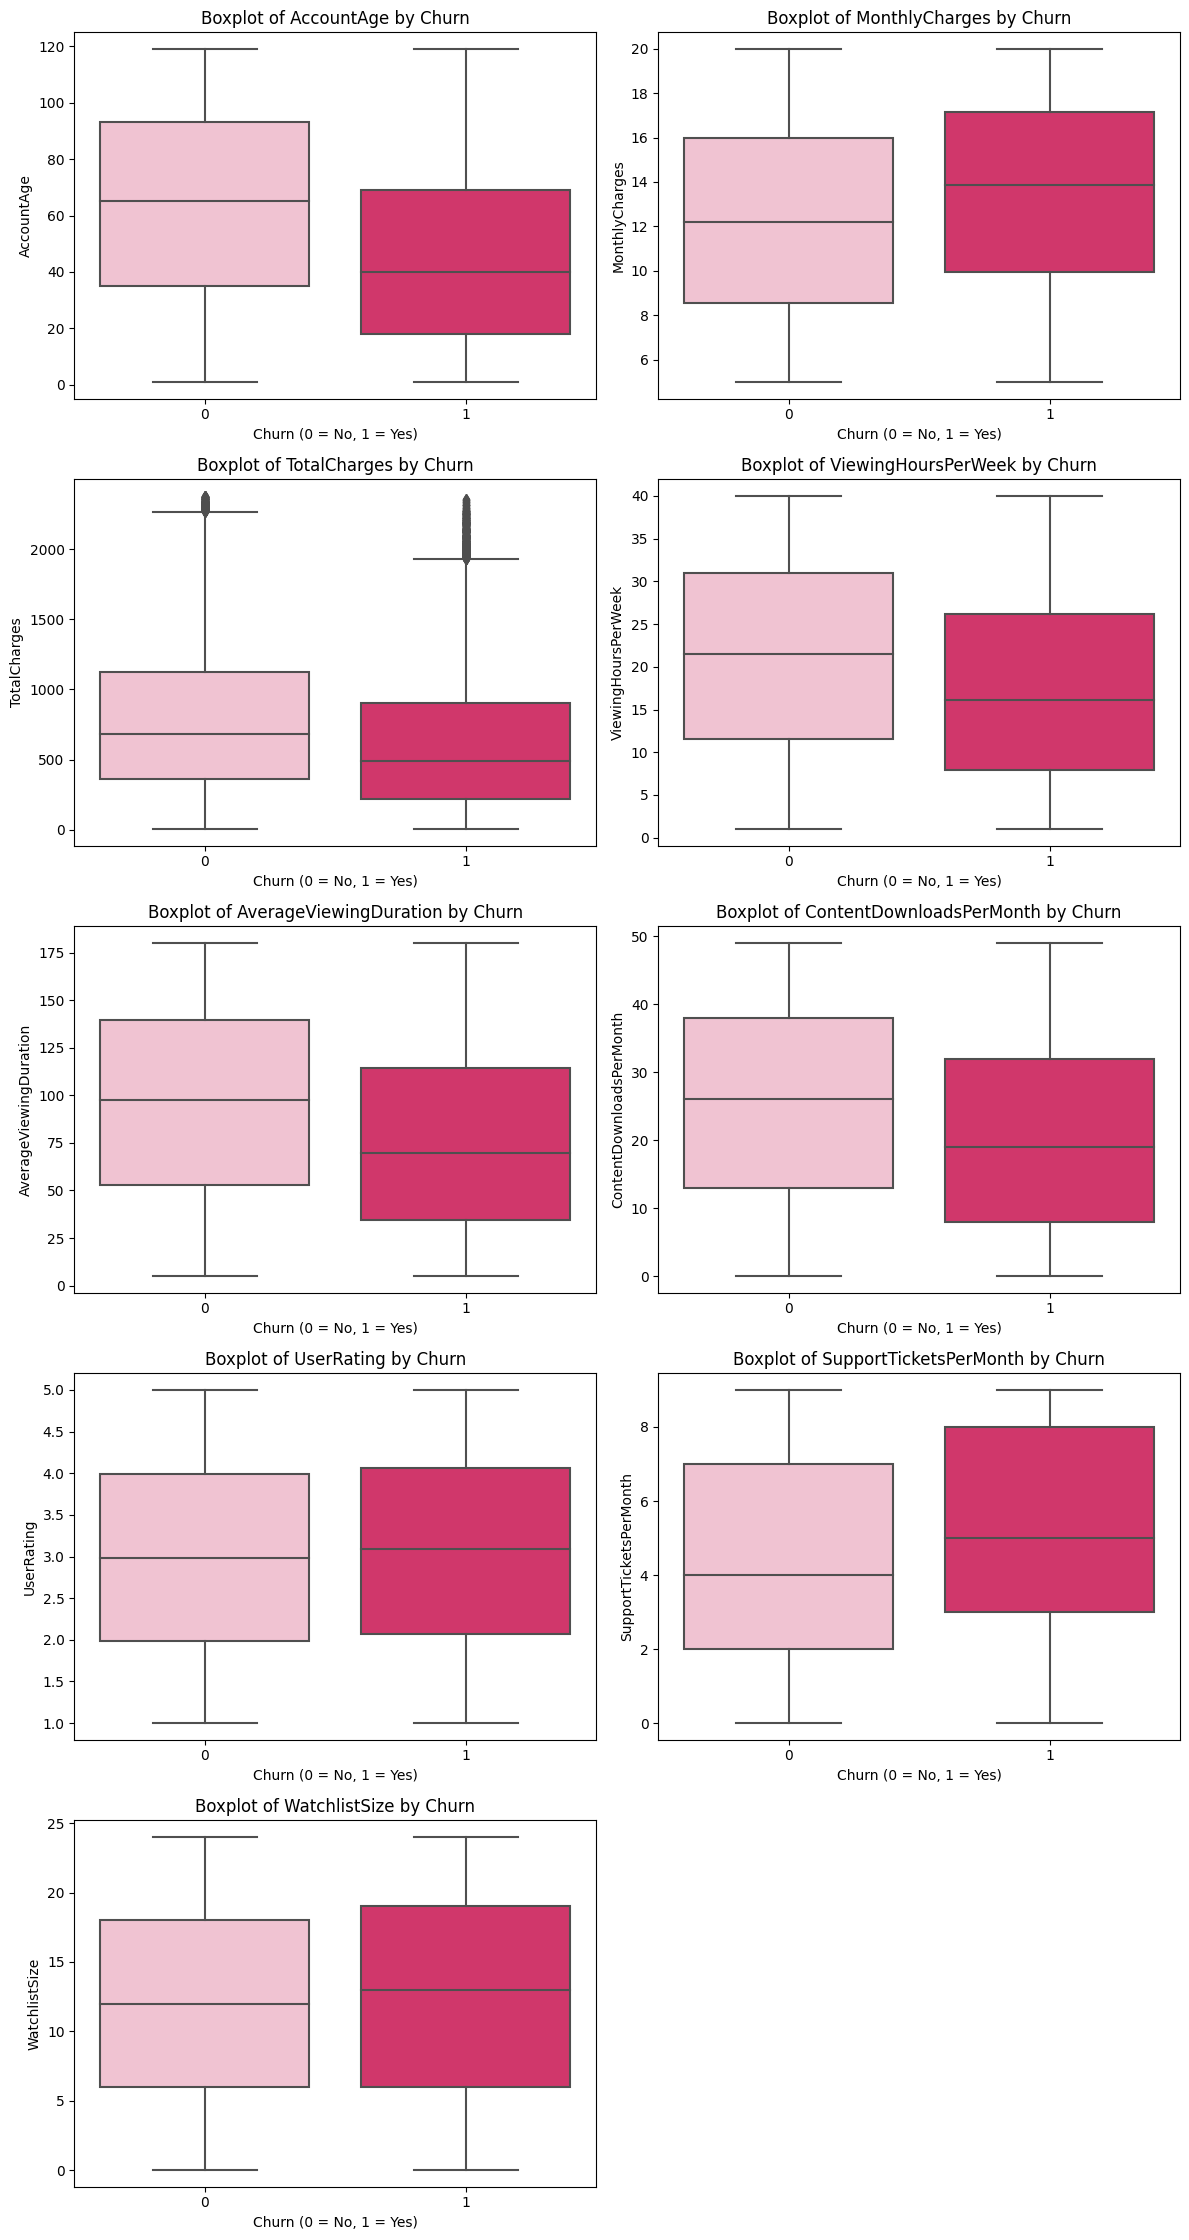

In [16]:
if significant_numeric:
    n_cols = 2
    n_plots = len(significant_numeric)
    n_rows = (n_plots + n_cols - 1) // n_cols 
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols * 6, n_rows * 4.5))
    if n_rows == 1:
        axes_flat = axes
    else:
        axes_flat = axes.flatten()
        
    for i, col in enumerate(significant_numeric):
        ax = axes_flat[i]
        sns.boxplot(x='Churn', y=col, data=df, palette=['#F8BBD0', '#E91E63'], ax=ax)
        ax.set_title(f'Boxplot of {col} by Churn')
        ax.set_xlabel('Churn (0 = No, 1 = Yes)')
        ax.set_ylabel(col)

    for i in range(n_plots, len(axes_flat)):
        axes_flat[i].set_visible(False)
    plt.tight_layout()
    plt.show()

Bar plots for category data
-

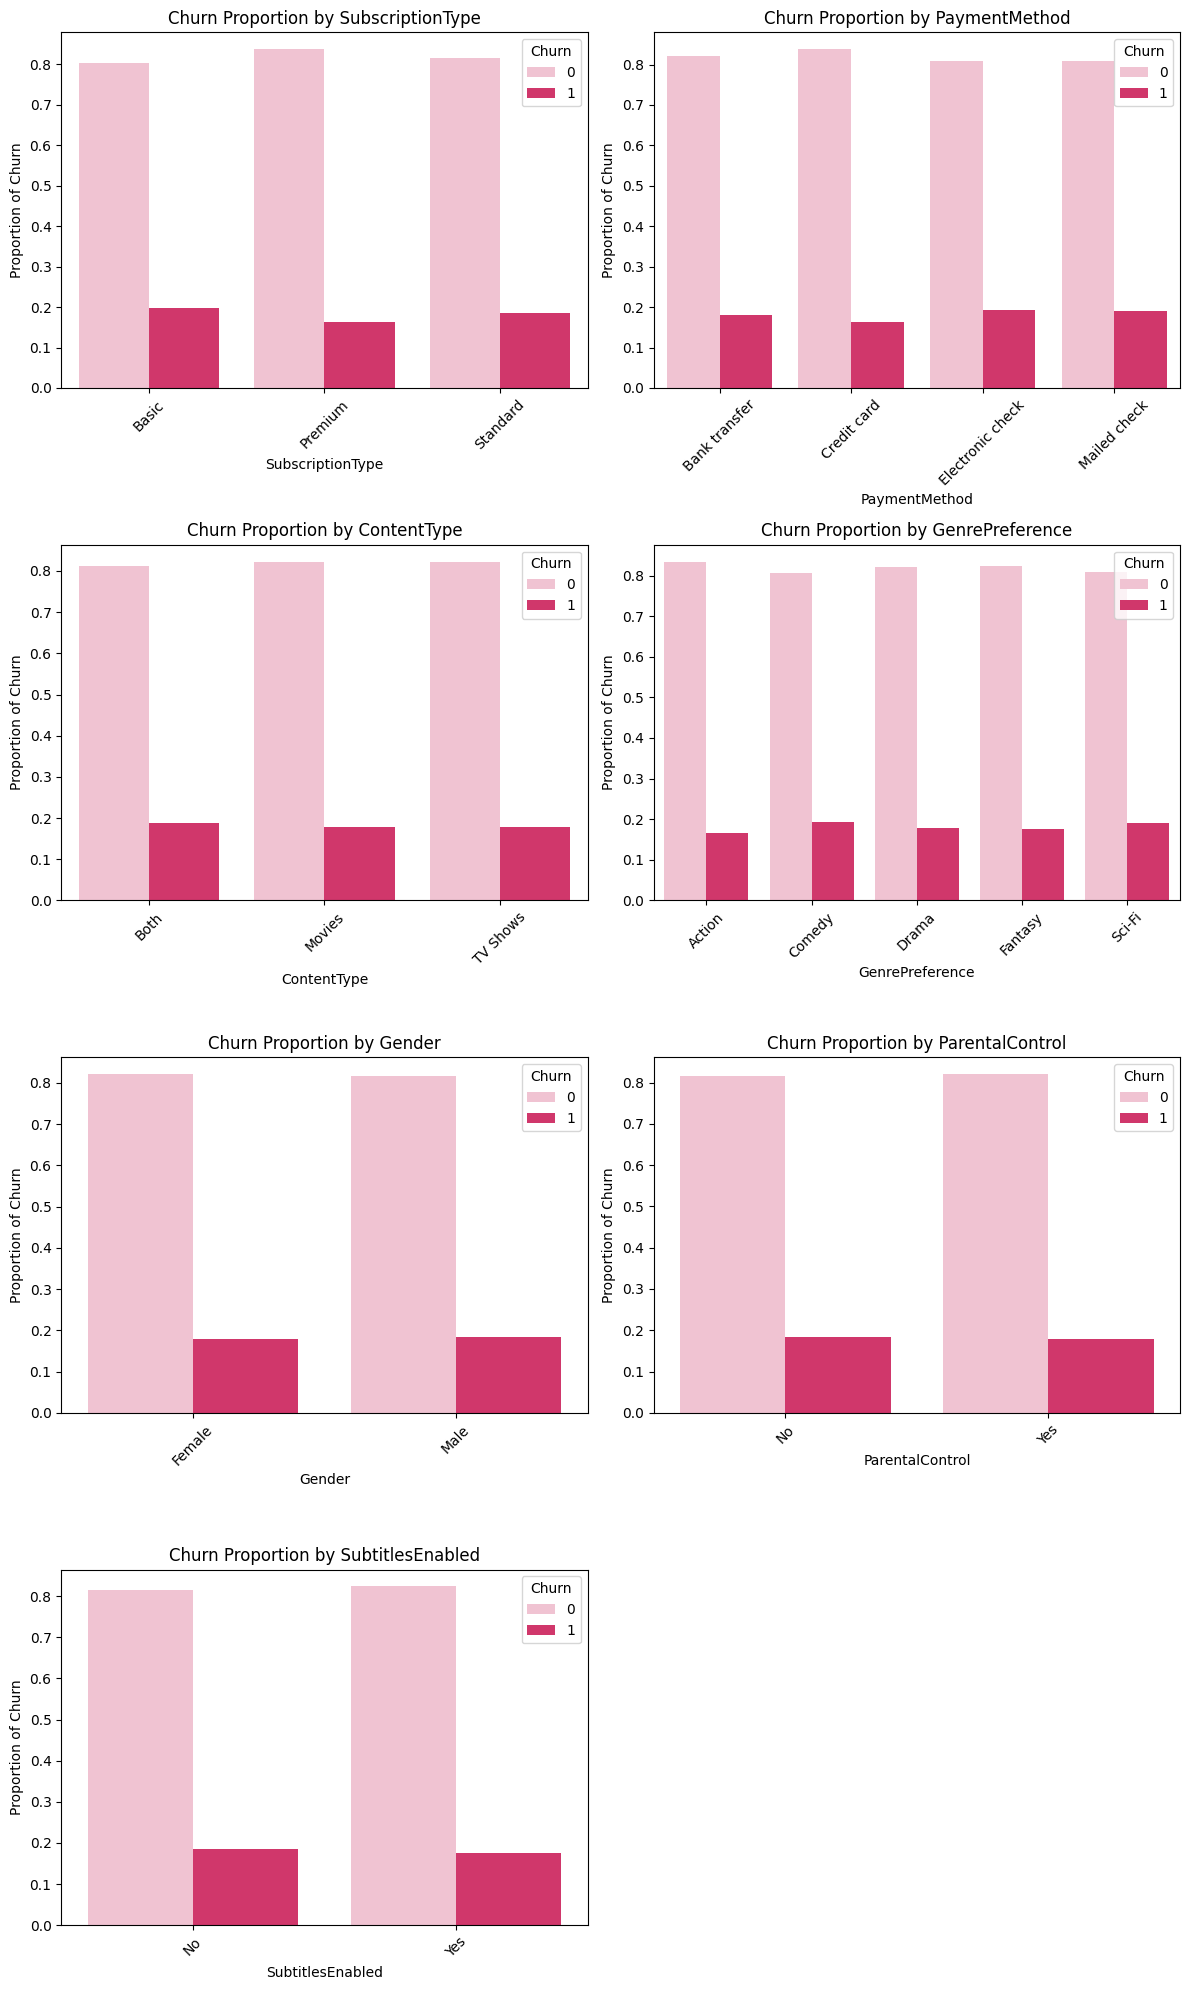

In [15]:
if significant_categorical:    
    n_cols = 2
    n_plots = len(significant_categorical)
    n_rows = (n_plots + n_cols - 1) // n_cols 
    
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols * 6, n_rows * 5)) # Tăng chiều cao một chút cho nhãn x

    if n_rows == 1:
        if n_plots == 1:
            axes_flat = [axes]
        else:
            axes_flat = axes
    else:
        axes_flat = axes.flatten()

    for i, col in enumerate(significant_categorical):
        prop_df = (df.groupby([col, 'Churn']).size() / df.groupby(col).size()).reset_index(name='Proportion')
        ax = axes_flat[i]
        sns.barplot(x=col, y='Proportion', hue='Churn', data=prop_df, palette=['#F8BBD0', '#E91E63'], ax=ax)
        ax.set_title(f'Churn Proportion by {col}')
        ax.set_xlabel(col)
        ax.set_ylabel('Proportion of Churn')
        ax.tick_params(axis='x', rotation=45) 
        ax.legend(title='Churn')

    for i in range(n_plots, len(axes_flat)):
        axes_flat[i].set_visible(False)
    plt.tight_layout()
    plt.show()